# Part 1

# 1.1:


In this section, we are going to get access to data provided by Wikimedia, specifically, number of pageviews for "Influenza" page. Using their API, we can get the pageview number as json file, which should be processed further. Processing this data includes aggregating pageview count to week scale, since data is provided in day scale. Considering limitation of data, this tool of Wikimedia had been started from July of 2015, therefore, we will take data from that time until now.  

In [1]:
import json
import datetime   #library for converting date to week number of a year
from ast import literal_eval 
import pandas as pd
import urllib
import matplotlib.pyplot as plt

In [2]:
main='https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/' #main part of url 
platform ='it.wikipedia/'                        #here we selected wikipedia platform for Italy
access='all-access/'                             #all access including mobile, desktop and tablet
who='user/'                                      #we are interested in users (not spider or bots)
pagename='Influenza/'                            #name of page
date='daily/20150601/20181202'                   #date and scale for data


url = main+platform+access+who+pagename+date
response = urllib.request.urlopen(url)
data = response.read()          # a `bytes` object
text = data.decode('utf-8')     #converting from bytes object into string
tup = literal_eval(text)        #unstring the object

In [3]:
#this function takes dictionary data, and then returns dataframe containing pageview numbers in year-week scale  

def year_week_pageview(tup):    
    table=pd.DataFrame(columns=["Year", "Week", "Pageview"])    #creating empty dataframe with the columns
    for i in range(len(tup['items'])):
        year=int(tup['items'][i]['timestamp'][:4])
        month=int(tup['items'][i]['timestamp'][4:6])
        day=int(tup['items'][i]['timestamp'][6:8])
        date=datetime.date(year, month, day).isocalendar()      #getting year and week number for current date
        table=table.append({"Year": date[0], "Week": date[1], "Pageview": int(tup['items'][i]['views'])},
                          ignore_index=True)
    grouped=table.groupby(['Year','Week'])['Pageview'].sum().reset_index(name="Pageview")   #grouping by year and then by week
    return(grouped)

In [4]:
df=year_week_pageview(tup)
df.head(5)

,Year,Week,Pageview
0,2015,27,493
1,2015,28,642
2,2015,29,646
3,2015,30,584
4,2015,31,554


In [5]:
df.shape    #overall 179 weeks 

(179, 3)

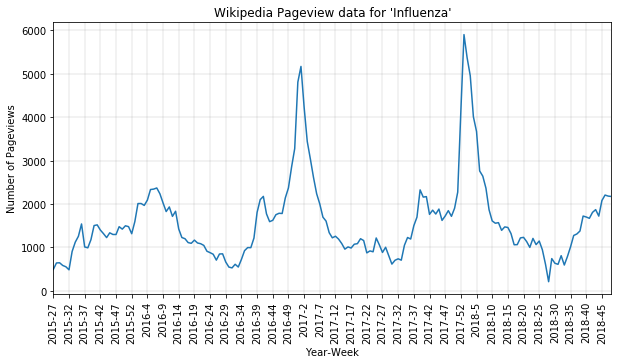

In [6]:
#here we will plot Pageview number for "Influenza" versus year-week 


index=[]
index=df['Year'].apply(str)+"-"+df['Week'].apply(str)  #creating index for x axis 


ax=df.plot(x=index, y='Pageview', title="Wikipedia Pageview data for 'Influenza'",rot=90, figsize=(10,5), legend=False,
            kind="line", xticks=range(0, 179, 5))   #plot, and x axis ticks for every 5 year-week index


ax.set_xlabel("Year-Week")
ax.set_ylabel("Number of Pageviews")
ax.grid( linewidth='0.2', color='grey')
plt.show()

# 1.2:


In this part, we will extract tables from Influnet pdf files using Tabula, and compare them against "Influenza" Wikipedia data in terms of correlation and fitness. Influnet shows data from 1st to 17th week and from 42nd to 52/53 th week for each year. That is why, our Wikipedia data should be mached in these periods.

In [7]:
import numpy
import sklearn.metrics

In [8]:
#after extracting tables from the pdfs, we can access them by csv reader of python

data_15_16=pd.read_csv(r'C:path\tabula-InfluNet - Stagione 2015 - 2016.csv',
                sep=",")
data_16_17=pd.read_csv(r'C:path\tabula-InfluNet - Stagione 2016 - 2017.csv',
                sep=",")
data_17_18=pd.read_csv(r'C:path\tabula-InfluNet - Stagione 2017 - 2018.csv',
                sep=",")

data_15_16.head(5)

,Unnamed: 0,Totale,Totale.1,Totale.2,Incidenza,0 - 4,5 - 14,15 - 64,65 e oltre
0,Settimana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Medici,Casi,Assistiti,Totale,Casi Inc,Casi Inc,Casi Inc,Casi Inc
2,2015-42,821,425,1.065.225,"0,40","75 1,11","60 0,42","228 0,37","62 0,26"
3,2015-43,928,604,1.204.096,"0,50","112 1,45","82 0,51","330 0,47","80 0,30"
4,2015-44,956,842,1.245.366,"0,68","156 1,91","108 0,64","469 0,65","109 0,40"


As we can see, we need to take values from the second row for the 1st column and 5th column, namely "Unnamed: 0" and "Incidenza". Here, Incidenza shows number of cases per 1000 people.

In [9]:
#filtering data and merging them together
d1=data_15_16[["Unnamed: 0", "Incidenza"]].iloc[2:]
d2=data_16_17[["Unnamed: 0", "Incidenza"]].iloc[2:]
d3=data_17_18[["Unnamed: 0", "Incidenza"]].iloc[2:]
merged=pd.concat([d1, d2,d3], ignore_index=True)
merged.head(5)

,Unnamed: 0,Incidenza
0,2015-42,"0,40"
1,2015-43,"0,50"
2,2015-44,"0,68"
3,2015-45,"0,76"
4,2015-46,"0,88"


At this point, we should modify this table. First of all,we will take out values from column "Unnamed:0" and write them sperately as Year and Week for new columns "Year" and "Week" respectively. Secondly, we need change format of "Incidenza" column values (ex. from '0,4' to 0.4), that is, replace commas with dots and convert from string to float type

In [10]:

influnet=pd.DataFrame()   #create new dataframe

influnet['Year'], influnet['Week'] = merged['Unnamed: 0'].str.split('-', 1).str    #split year and week
influnet['Influnet']=merged['Incidenza']   
influnet['Influnet']=influnet['Influnet'].apply(lambda x: float(x.replace(',', '.'))) #replace commas with dots
influnet['Year']=influnet['Year'].apply(int)    #from str to int
influnet['Week']=influnet['Week'].apply(int)

influnet.head(5)

,Year,Week,Influnet
0,2015,42,0.40
1,2015,43,0.50
2,2015,44,0.68
3,2015,45,0.76
4,2015,46,0.88


Now, we will join "Influenza" dataframe from the previous part into this dataframe on columns Year and Week

In [11]:
comb=pd.merge(df, influnet, on=["Year","Week"])
comb.head(5)

,Year,Week,Pageview,Influnet
0,2015,42,1400,0.40
1,2015,43,1317,0.50
2,2015,44,1226,0.68
3,2015,45,1336,0.76
4,2015,46,1298,0.88


In [12]:
comb.shape

(84, 4)

Combined table has 84 weeks

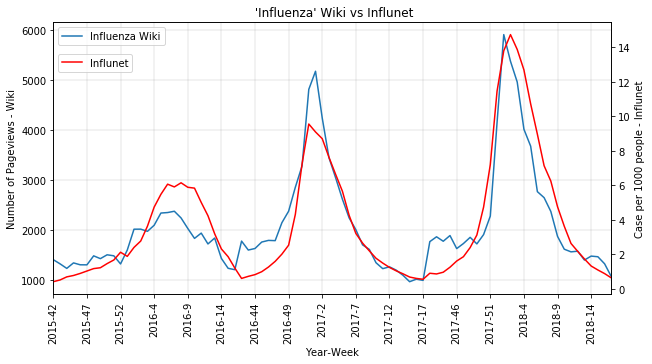

In [13]:
index=[]

index=comb['Year'].apply(str)+"-"+comb['Week'].apply(str)
ax=comb.plot(x=index, y='Pageview', title=" 'Influenza' Wiki vs Influnet",rot=90, figsize=(10,5), legend=False,
            kind="line", xticks=range(0, 84, 5))

ax2 = ax.twinx()
comb.plot(x=index, y=['Influnet'],ax=ax2, color='r',rot=90, figsize=(10,5), legend=True,
            kind="line", xticks=range(0, 84, 5))
ax2.set_ylabel("Case per 1000 people - Influnet")
ax2.legend(bbox_to_anchor=(-0.85, 0.8, 1., .102))
ax.legend(labels=('Influenza Wiki',))
ax.set_xlabel("Year-Week")
ax.set_ylabel("Number of Pageviews - Wiki")
ax.grid( linewidth='0.2', color='grey')
plt.show()

Here, we will calculate Pearson correlation coefficient for Influenza and Influnet data for different lags of time. That is, we will shift time scale for Wikipedia data, calling changing lags, to see how correlations change. For example, Wiki-1 means that we will correlate Wikipedia Data for week n-1 with Influnet data in week n. 

In [14]:
lag_corr=pd.DataFrame(columns=['Wiki','Wiki-1','Wiki-2','Wiki+1','Wiki+2']) #creating empty table 

#pearson correlation coeficcient for different lags
lag_corr=lag_corr.append({'Wiki':round( numpy.corrcoef(comb["Pageview"], comb["Influnet"])[0, 1],3),
                         'Wiki-1':round(numpy.corrcoef(comb["Pageview"].iloc[:83], comb["Influnet"].iloc[1:])[0, 1],3), 
                         'Wiki-2':round(numpy.corrcoef(comb["Pageview"].iloc[:82], comb["Influnet"].iloc[2:])[0, 1],3),
                         'Wiki+1':round(numpy.corrcoef(comb["Pageview"].iloc[1:], comb["Influnet"].iloc[:83])[0, 1],3),
                         'Wiki+2':round(numpy.corrcoef(comb["Pageview"].iloc[2:], comb["Influnet"].iloc[:82])[0, 1],3)},
                                        ignore_index=True)

lag_corr.rename(index={0: 'Influnet'}, inplace=True)
print("Correlation for different lags:")
lag_corr


Correlation for different lags:


,Wiki,Wiki-1,Wiki-2,Wiki+1,Wiki+2
Influnet,0.918,0.897,0.805,0.847,0.688


Discussion: from figure above we can say that 'Influenza' wiki data and Influnet data have similar behaviour over time, that is, trends in Influnet coincides with trends in 'Influenza' wiki data. In order to see how they correlate, we calculated Pearson correlation coefficient for different time lags between them. Pearson correlation coefficient was chosen based on the provided article "mciver2014_fluwikipedia" in which authors used it. As a result, when there is not shifts in weeks between them, we observed highest value which is equal to 0.918. The second highest value was found for -1 week shift for wiki data, specifically, when wiki data in week n-1 were compared with Influnet data in week n. However, correlation for time series data should be considered carefully, because it could rise wrong assumptions. Pearson correlation coefficient can accurately show result for linear relationship, but in our case we have non-monotonic relationship. Nevertheless, Pearson correlation coefficient can be used in cases when we have stationary time series data with no significant trend. In our case time series data can be considered as weak stationary. So, in order to strenghten our assumptions about correlation, we can propose R square method, which will define how both data fitted to each other. Main idea behind this method is calculation of sum of squared errors for each pair of Wiki and Influnet data. Maximum value of R square could be 1, which indicates to perfect fitness of two data. Before conducting R square analysis, we need to normalize both data, because wiki data has value between 1000 and 6000, and range of Influnet is between 0 and 15. So, to normalize them in scale between 0 and 1, we can use following equation:
                    
                                        norm_x=(x-min_x)/(max_x-min_x)
                    

In [15]:
#normalizing data into scale from 0 to 1
normalized=pd.DataFrame()
normalized['Year']=comb['Year']
normalized['Week']=comb['Week']
normalized["influenza_norm"]=(comb['Pageview']-min(comb["Pageview"]))/(max(comb["Pageview"])-min(comb["Pageview"]))
normalized["influnet_norm"]=(comb["Influnet"]-min(comb["Influnet"]))/(max(comb["Influnet"])-min(comb["Influnet"]))

In [16]:
print('Normalized data:')
normalized.head(5)

Normalized data:


,Year,Week,influenza_norm,influnet_norm
0,2015,42,0.089033,0.000000
1,2015,43,0.072238,0.006974
2,2015,44,0.053824,0.019526
3,2015,45,0.076083,0.025105
4,2015,46,0.068393,0.033473


Lets plot and compare normalized Influenza wiki and Influnet data

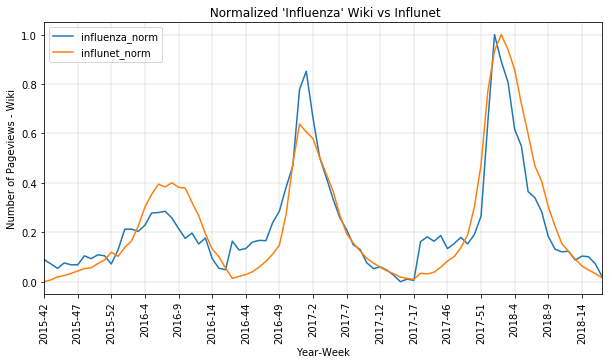

In [17]:
index=[]
index=normalized['Year'].apply(str)+"-"+normalized['Week'].apply(str)

ax=normalized.plot(x=index, y=['influenza_norm','influnet_norm'], title=" Normalized 'Influenza' Wiki vs Influnet",rot=90, figsize=(10,5), legend=True,
            kind="line", xticks=range(0, 84, 5))



ax.set_xlabel("Year-Week")
ax.set_ylabel("Number of Pageviews - Wiki")
ax.grid( linewidth='0.2', color='grey')
plt.show()

As we can see, this shows exactly the same plot as the previous one. Now, when we have data in the same scale we can calculate R square to evaluate fitness to each other. 

In [18]:
import sklearn.metrics
sklearn.metrics.r2_score(normalized['influenza_norm'], normalized['influnet_norm'])

0.791984435074526

In [19]:
lag_r2=pd.DataFrame(columns=['Wiki','Wiki-1','Wiki-2','Wiki+1','Wiki+2']) #creating empty table 

#pearson correlation coeficcient for different lags
lag_r2=lag_r2.append({'Wiki':round( sklearn.metrics.r2_score(normalized['influenza_norm'], normalized['influnet_norm']),3),
                         'Wiki-1':round(sklearn.metrics.r2_score(normalized['influenza_norm'].iloc[:83], normalized['influnet_norm'].iloc[1:]),3), 
                         'Wiki-2':round(sklearn.metrics.r2_score(normalized['influenza_norm'].iloc[:82], normalized['influnet_norm'].iloc[2:]),3),
                         'Wiki+1':round(sklearn.metrics.r2_score(normalized['influenza_norm'].iloc[1:], normalized['influnet_norm'].iloc[:83]),3),
                         'Wiki+2':round(sklearn.metrics.r2_score(normalized['influenza_norm'].iloc[2:], normalized['influnet_norm'].iloc[:82]),3)},
                                        ignore_index=True)

lag_r2.rename(index={0: 'Influnet'}, inplace=True)
print("R square for different lags:")
lag_r2

R square for different lags:


,Wiki,Wiki-1,Wiki-2,Wiki+1,Wiki+2
Influnet,0.792,0.744,0.536,0.631,0.271


Table above shows when lag is zero between data, there is high fitness between them. Also, there is good fitness when lag is -1, that is, when wiki data in a week compared with influnet data of the next week. In conclusion, there is correlation between these data, and for further considerations in correlation we will consider lag=0 no shift between them

# Part 2

# 2.1

In this part we have to choose wikipedia pages, which correlate with Influnet data. First of all, I looked at symptoms of influenza such as temperature, rhinorrhoea, mialgia, cefalea, vomito and tosse. Secondly, I choose a page about virus itself called 'Orthomyxoviridae'. This is a family of RNA viruses that includes different type of Influenza viruses. Lastly, I picked up pages devoted for treatment of the virus. Here, the most important one is the page "Paracetamolo". Furthermore, if we search in Google for "trattamento dell'influenza", articles in the top results state that medicine with brand name 'Tamiflu','Ibuprofene' and 'Zanamivir' could be effective in treating the influenza. Therefore, I looked for their wiki pages and found that for 'Tamiflu' we have medical name called "Oseltamivir" on wikipedia, and for others it is the same as their names. For the last page, I selected 'Vaccino antinfluenzale', which is about vaccination to prevent yourself from influenza. So, I have 12 pages in total. 

Let's create a function that will take as input Wiki page names, and return dataframe with pagenumber in weekly scale for each page and influnet data

In [20]:
def pages(page_list, influnet_data):
    main=influnet_data
    ull='https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/it.wikipedia/all-access/user/'
    date='/daily/20150601/20181202'    
    for page in page_list:
        url=ull+page+date
        response = urllib.request.urlopen(url)
        data = response.read()        
        text = data.decode('utf-8')     
        tup = literal_eval(text)
        page_data=year_week_pageview(tup)
        #since it returns column "Pageview", we have to change to corresponding value
        page_data.rename(columns={'Pageview':page}, inplace=True)  
        main=pd.merge(main, page_data, on=["Year","Week"])
    #main=pd.merge()
    return(main)

In [21]:
from IPython.display import display, HTML   #this for display of dataframes

In [22]:
page_list=['Febbre', 'Paracetamolo', 'Rinorrea', 'Orthomyxoviridae', 'Oseltamivir', 'Zanamivir', 'Ibuprofene',
          "Cefalea",'Mialgia', 'Vomito','Tosse', 'Vaccino antinfluenzale' ]  #page names


corr=pd.DataFrame(index=['Influnet'],columns=page_list)     #table for correlation
r2=pd.DataFrame(index=['Influnet'],columns=page_list)       #table for r square
v=pages(page_list, influnet)
page_list.append('Influnet')
var_list=page_list
w=v.copy()


At this point, lets draw for each page their time series behaviour in weekly base comparing with Influnet data.

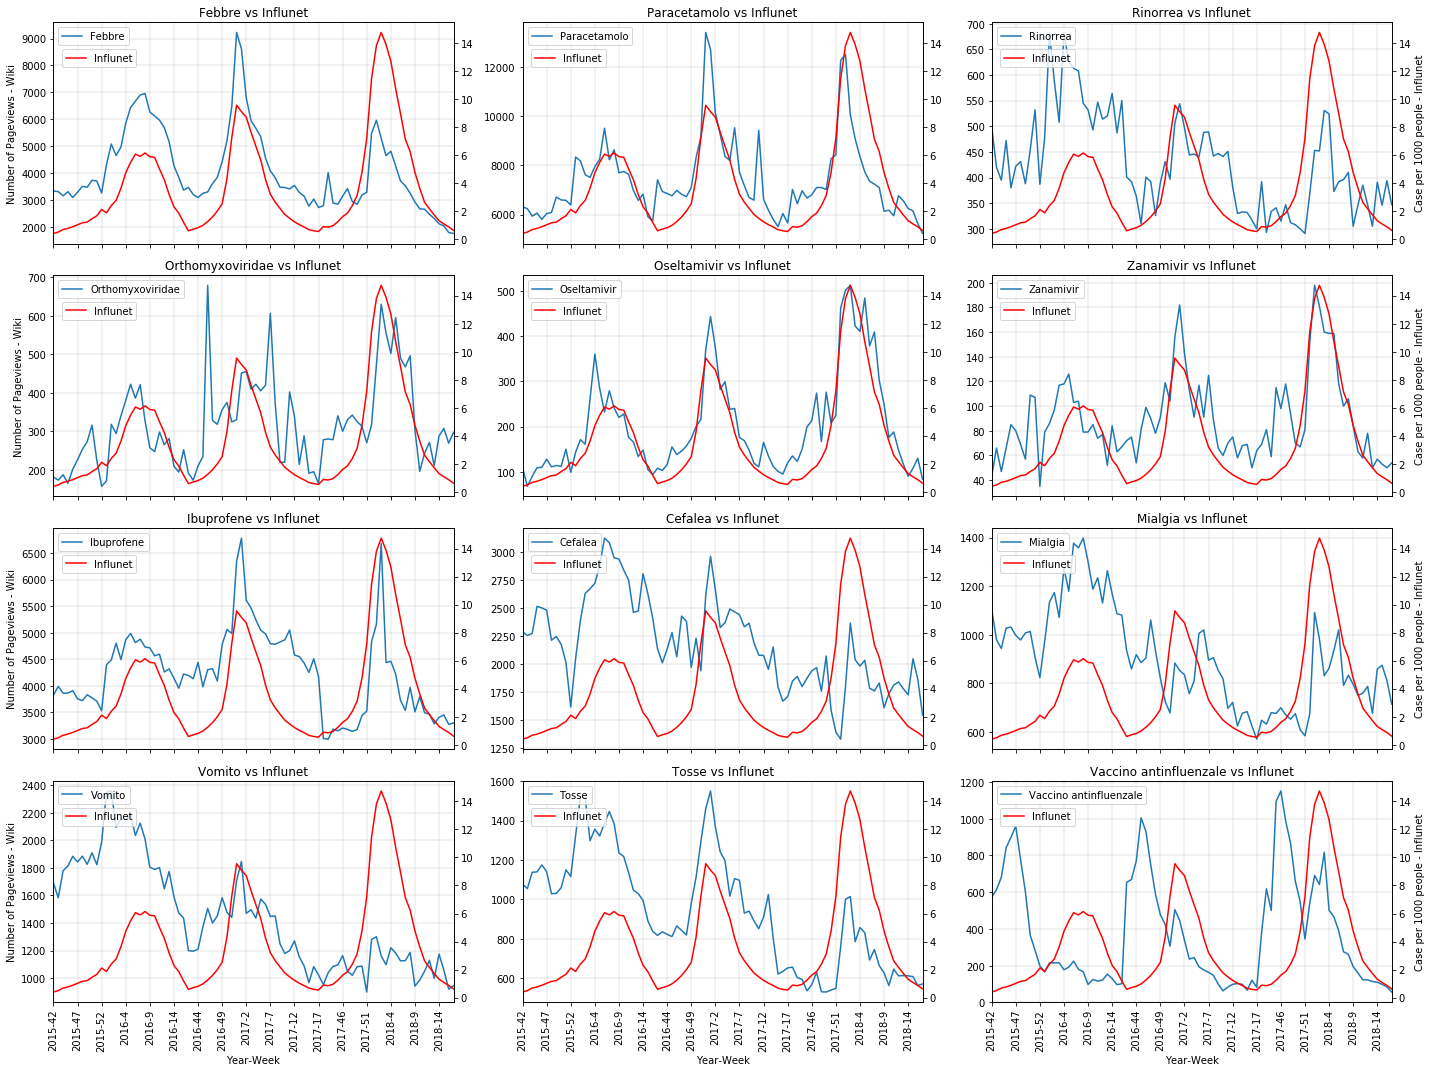

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3)   #for total 12 plots, I create subplot with shape(rows=4, colms=3)
for i, ax in enumerate(axes.reshape(-1)):
     v.plot(x=index, y=page_list[i],ax=ax, title=page_list[i]+" vs Influnet",rot=90, figsize=(20,15), legend=True)
     ax2 = ax.twinx()        #stacking Influnet data into a page's plot
     v.plot(x=index, y='Influnet',ax=ax2, color='r',rot=90, figsize=(20,15), legend=True,
                kind="line", xticks=range(0, 84, 5))
    
     ax2.legend(bbox_to_anchor=(-0.78, 0.8, 1., .102))
     
     ax.set_xlabel("Year-Week")
     ax.legend(loc='upper left')
     ax.grid( linewidth='0.2', color='grey')
        
     #here to place y and x  axis names properly, I only put them on the first and last plots
     if (i in [0,3,6,9]):
        ax.set_ylabel("Number of Pageviews - Wiki")
     elif (i in [2,5,8,11]): 
        ax2.set_ylabel("Case per 1000 people - Influnet")
        
plt.tight_layout()
plt.show()

From plots we can see that Febbre, Paracetamolo, Oseltamivir and Zanamivir show good correlation. Mialgia, Cefalea and Vomito have similar trend over time. These symptoms are also symptoms of other illnesses, and therefore they could show different trend than influenza. It should be noted that 'Vaccino antiinfluenzale' gets peak values some weeks before influenza gets the peak, it is expected, since people will do vaccination before the season.  

# 2.2

Now, let's compute correlation and fittness of number of views for each page with Influnet data. 

In [24]:
corr=pd.DataFrame(index=['Influnet'],columns=page_list[:12])
r2=pd.DataFrame(index=['Influnet'],columns=page_list[:12])
for i in page_list:
    if (i!='Influnet'):
        corr[i]['Influnet']=round( numpy.corrcoef(w[i], w["Influnet"])[0, 1],3)
    w[i]=(w[i]-min(w[i]))/(max(w[i])-min(w[i]))    #this normalisation is neccessary to find R square
for i in page_list:    
    if (i!='Influnet'):
        r2[i]['Influnet']=round(sklearn.metrics.r2_score(w[i], w['Influnet']),3)
print("Correlation table:")
display(corr)

print('R square table:')
display(r2)

Correlation table:


,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Zanamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Tosse,Vaccino antinfluenzale
Influnet,0.633,0.763,0.296,0.661,0.924,0.816,0.548,0.099,0.147,0.014,0.242,0.013


R square table:


,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Zanamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Tosse,Vaccino antinfluenzale
Influnet,-0.122,0.324,-0.703,0.118,0.771,0.295,-0.349,-2.168,-1.185,-1.121,-0.726,-0.858


The highest correlation is for the page 'Oseltamivir' and this is even higher than page 'Influenza', and also R square for this page is higher. Furthermore, Zanamivir and Paracetamolo also show good correlation, and comparitavely good R square. Among symptom pages, Febbre is comparetavely in good correlation with Influnet. Indeed, people with influenza ,high likely, will look for treatment of the illness, while temperature and other symptoms could indicate to other illnesses. Therefore, we can say pages devoted for treating influenza could be good source of information for predicting influenza incidence.  

# Part 3

# 3.1

For the prediction of the influenza incidence, I will use the model proposed by the article, namely, generalized linear model with poisson distribution using log-link function. Actually, poisson regresson is used for count data, which is the case for the influenza. Furhermore, to prevent overfitting the proposed model will have early stopping, which will control how test and train improves, and reqularization term L1, which will penalize coefficients to some degree alpha. For the loss function, added regularization term will be:

                                        reg_term=alpha*||beta||
  here, ||beta|| - root of squared sum of all coefficients.
This alpha will be hyperparameter of our model, which should be chosen in appropriate way to decrease error. In order to evaluate the performance of the model, root mean squared error (RMSE) metric is used. Due to limitation data, K-Fold cross-validation is conducted, and as number of folds I selected 4,which for 84 weeks gives 21 test set (25%) and 63 train set (75%). For the feature selection, we need to filter out highly mutually correlated features. Therefore, before running model, I will do cross-correlation and drop all features which corr. coefficient higher than 0.8.

I will use XGBoost package for running the model. This package allows us to do extreme gradient boosting algorithm using parallel and fast learning computation. 

To visualize the performance of the model, I will plot real influnet vs predicted results from K-Fold validation by averaging of each fold results.
    

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

In [26]:
copy=v.copy()  # let's copy data from previous part 

In [27]:
ff=pd.DataFrame()
ff['Influenza']=comb['Pageview']    
copy=pd.concat([copy, ff], axis=1)         #adding new column Influenza from part 1


In [28]:
x=copy[['Febbre', 'Paracetamolo', 'Rinorrea', 'Orthomyxoviridae', 'Oseltamivir', 'Zanamivir', 'Ibuprofene',
          "Cefalea",'Mialgia', 'Vomito','Tosse', 'Vaccino antinfluenzale','Influenza' ]]   #predictors
y=copy[['Influnet']]    #target ouput
copy.head(5)

,Year,Week,Influnet,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Zanamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Tosse,Vaccino antinfluenzale,Influenza
0,2015,42,0.40,3330,6318,500,181,109,43,3828,2289,1106,1691,1077,572,1400
1,2015,43,0.50,3307,6241,420,173,68,66,3991,2256,980,1583,1055,614,1317
2,2015,44,0.68,3150,5937,395,187,90,47,3863,2274,944,1779,1138,681,1226
3,2015,45,0.76,3305,6064,472,165,109,66,3865,2516,1028,1814,1140,842,1336
4,2015,46,0.88,3088,5805,380,201,110,85,3911,2503,1032,1884,1175,899,1298


In [29]:
#let's do cross - correlation 
correlation=x.corr(method='pearson').abs()
correlation.style.background_gradient().set_precision(2)

,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Zanamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Tosse,Vaccino antinfluenzale,Influenza
Febbre,1,0.78,0.66,0.37,0.58,0.62,0.78,0.65,0.5,0.56,0.77,0.11,0.67
Paracetamolo,0.78,1,0.36,0.5,0.74,0.76,0.71,0.23,0.12,0.21,0.45,0.064,0.85
Rinorrea,0.66,0.36,1,0.22,0.24,0.32,0.53,0.75,0.78,0.75,0.79,0.28,0.26
Orthomyxoviridae,0.37,0.5,0.22,1,0.7,0.73,0.4,0.11,0.074,0.041,0.11,0.1,0.65
Oseltamivir,0.58,0.74,0.24,0.7,1,0.87,0.48,0.084,0.085,0.0091,0.19,0.12,0.88
Zanamivir,0.62,0.76,0.32,0.73,0.87,1,0.57,0.18,0.11,0.11,0.31,0.25,0.88
Ibuprofene,0.78,0.71,0.53,0.4,0.48,0.57,1,0.54,0.31,0.37,0.68,0.2,0.62
Cefalea,0.65,0.23,0.75,0.11,0.084,0.18,0.54,1,0.79,0.71,0.77,0.11,0.12
Mialgia,0.5,0.12,0.78,0.074,0.085,0.11,0.31,0.79,1,0.75,0.66,0.13,0.067
Vomito,0.56,0.21,0.75,0.041,0.0091,0.11,0.37,0.71,0.75,1,0.88,0.067,0.026


There are high correlations for Paracetamolo, Influenza, Tosse and etc.
Let's remove them

In [30]:
# choose upper triangle of correlation matrix
upp= correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))

# Find and drop features which have correlation coeff higher than 0.8
to_drop = [column for column in upp.columns if any(upp[column] > 0.8)]
x=x.drop(x[to_drop], axis=1)
x.head(5)

,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Vaccino antinfluenzale
0,3330,6318,500,181,109,3828,2289,1106,1691,572
1,3307,6241,420,173,68,3991,2256,980,1583,614
2,3150,5937,395,187,90,3863,2274,944,1779,681
3,3305,6064,472,165,109,3865,2516,1028,1814,842
4,3088,5805,380,201,110,3911,2503,1032,1884,899


In [31]:
#number of folds = 4, random state as last 4 digits of my ID
K = 4
kf = KFold(n_splits = K, random_state = 1856, shuffle = True)  

In [32]:
train = np.array(x)    #our variables
target_train = np.array(y)   #target output

In [33]:
#our model
def poiss_model(train, target_train, kf, alpha):   
    
    xgb_preds=[]      #to store predicted values
    progress=dict()   #to see at each iteration RMSE values
    error=[]
    for train_index, test_index in kf.split(train):

        

        #Cross-validation
        train_X, valid_X = train[train_index], train[test_index]       
        train_y, valid_y = target_train[train_index], target_train[test_index]

        #parameters of model: Poisson regression, evaluation metric RMSE and regulation alpha 
        params = {'objective': 'count:poisson', 'seed': 1856, 'silent': 1, 'eval_metric':'rmse', 'reg_alpha':alpha}

        #convert to appropriate form for XGBoost
        d_train = xgb.DMatrix(train_X, train_y)
        d_valid = xgb.DMatrix(valid_X, valid_y)
        d_test = xgb.DMatrix(train)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]   #monitor these values

        model = xgb.train(params, d_train, 200,  watchlist, maximize=True, verbose_eval=False, early_stopping_rounds=50,
                         evals_result=progress)      #iteration number = 200

        error.append(progress['valid']['rmse'][-1])  #the final RMSE value of the model
        
        xgb_pred = model.predict(d_test)      #prediction 
        xgb_preds.append(list(xgb_pred))      #store prediction
    return (model, xgb_preds, error)            #return the model, predicted values and error

In [34]:
model, pred, error=poiss_model(train, target_train, kf, 0.1)   #running model with alpha = 0.1

In considering RMSE value, we need to evaluate how the RMSE is good, since it is not relative value and it depends on range of target output of what we are considering. In this case, good option could be computing normalized RMSE value relative to target output range, and it will give us intuitive evaluation of model. So:
                                
                                norm_RMSE= RMSE/(Influnet_max-Influnet_min)
                            
  
                               

In [35]:
print('RMSE :',round(np.mean(np.array(error)),2))
print('Nomalized RMSE as %:',round(100*np.mean(np.array(error))/(max(copy['Influnet'])-min(copy['Influnet'])),2))

RMSE : 1.36
Nomalized RMSE as %: 9.5


So, for alpha = 0.1, the model shows norm RMSE - 9.5%. Since alpha is tuning parameter, we need to search for the best value of alpha. 

In [36]:
#range of possible alpha values from 0 to 1 by 0.02 step
rg=numpy.arange(0, 1, 0.02)

results=[]   #
for alpha in rg:
    model, pred,error=poiss_model(train, target_train, kf, alpha)
    results.append(round(100*np.mean(np.array(error))/(max(copy['Influnet'])-min(copy['Influnet'])),2))

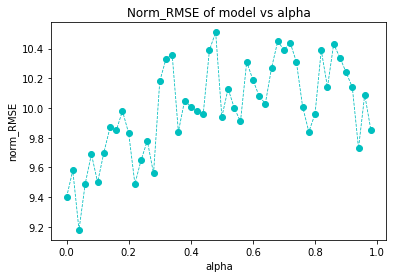

In [37]:
plt.plot(rg,results, color='c',marker='o', linestyle='dashed', linewidth=0.8)
plt.title('Norm_RMSE of model vs alpha')
plt.xlabel('alpha')
plt.ylabel('norm_RMSE')
plt.show()

So, from the plot, the best value for alpha is 0.04

In [38]:
#re running the model for alpha = 0.04
model, pred, error=poiss_model(train, target_train, kf, 0.04)
print('RMSE :',round(np.mean(np.array(error)),2))
print('Nomalized RMSE as %:',round(100*np.mean(np.array(error))/(max(copy['Influnet'])-min(copy['Influnet'])),2))

RMSE : 1.32
Nomalized RMSE as %: 9.18


Now, let's plot Influnet vs predicted from cross validation 

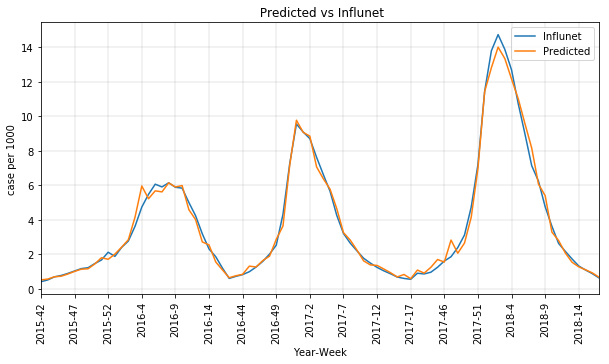

In [39]:

pp=np.array(pred)   #predicted results from the model
predicted=np.mean(pp, axis=0)     #taking mean value for each fold predicted values
copy['Predicted']=predicted           #add new column for predicted
index=[]
index=copy['Year'].apply(str)+"-"+copy['Week'].apply(str)

ax=copy.plot(x=index, y=['Influnet','Predicted'], title=" Predicted vs Influnet",rot=90, figsize=(10,5), legend=True,
            kind="line", xticks=range(0, 84, 5))


ax.set_xlabel("Year-Week")
ax.set_ylabel("case per 1000")
ax.grid( linewidth='0.2', color='grey')
plt.show()

So, our model showed RMSE = 1.32 and norm_RMSE=9.18% with alpha being equal to 0.04. Plot above also indicates to good fitness with real data. For the first and second peak of influenza, the model behaves good, but at the last peak point it underestimates the incidence.

# 3.2

In this part, we have to predict the incidence for the target week having data for Influnet and all Wiki pages for the preceding week. It means I have to shift rows for influnet and all pages, while keeping Influnet as new target output

In [40]:
target=pd.DataFrame()
preceding=pd.DataFrame()

In [41]:
#the target week
target[['Year', 'Week', 'Influnet']]=copy[['Year', 'Week', 'Influnet']].iloc[1:].reset_index(drop=True)   

#preceding week 
preceding[['In_pred','Febbre', 'Paracetamolo', 'Rinorrea', 'Orthomyxoviridae', 'Oseltamivir', 'Zanamivir', 'Ibuprofene',
          "Cefalea",'Mialgia', 'Vomito','Tosse', 'Vaccino antinfluenzale', 'Influenza' ]]=copy[['Influnet','Febbre', 'Paracetamolo', 'Rinorrea', 'Orthomyxoviridae', 'Oseltamivir', 'Zanamivir', 'Ibuprofene',
          "Cefalea",'Mialgia', 'Vomito','Tosse', 'Vaccino antinfluenzale', 'Influenza' ]].iloc[0:83].reset_index(drop=True)

In [42]:
new_data=pd.concat([target, preceding], axis=1)
new_data.head(5)

,Year,Week,Influnet,In_pred,Febbre,Paracetamolo,Rinorrea,Orthomyxoviridae,Oseltamivir,Zanamivir,Ibuprofene,Cefalea,Mialgia,Vomito,Tosse,Vaccino antinfluenzale,Influenza
0,2015,43,0.50,0.40,3330,6318,500,181,109,43,3828,2289,1106,1691,1077,572,1400
1,2015,44,0.68,0.50,3307,6241,420,173,68,66,3991,2256,980,1583,1055,614,1317
2,2015,45,0.76,0.68,3150,5937,395,187,90,47,3863,2274,944,1779,1138,681,1226
3,2015,46,0.88,0.76,3305,6064,472,165,109,66,3865,2516,1028,1814,1140,842,1336
4,2015,47,1.02,0.88,3088,5805,380,201,110,85,3911,2503,1032,1884,1175,899,1298


In [43]:
#creating training set
x=new_data[['In_pred','Febbre', 'Paracetamolo', 'Rinorrea', 'Orthomyxoviridae', 'Oseltamivir', 'Zanamivir', 'Ibuprofene',
          "Cefalea",'Mialgia', 'Vomito','Tosse', 'Vaccino antinfluenzale', 'Influenza' ]]

#creating target output
y=new_data[['Influnet']]

In [44]:
#correlation of features
correlation=x.corr(method='pearson').abs()

upp= correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))

# Find and drop features which have correlation coeff higher than 0.8
to_drop = [column for column in upp.columns if any(upp[column] > 0.8)]
x=x.drop(x[to_drop], axis=1)

In [45]:
train = np.array(x)
target_train = np.array(y)

Since we have new data for training our mode, we have to choose appropriate value for alpha in the same as in previous part

In [46]:
#range of possible alpha values from 0 to 1 by 0.02 step
rg=numpy.arange(0, 1, 0.02)

results=[]   #
for alpha in rg:
    model, pred,error=poiss_model(train, target_train, kf, alpha)
    results.append(round(100*np.mean(np.array(error))/(max(new_data['Influnet'])-min(new_data['Influnet'])),2))

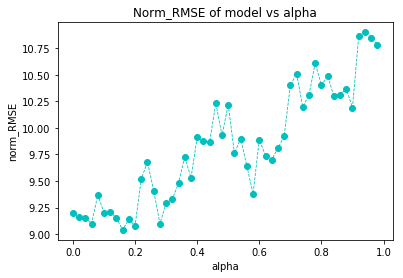

In [47]:
plt.plot(rg,results, color='c',marker='o', linestyle='dashed', linewidth=0.8)
plt.title('Norm_RMSE of model vs alpha')
plt.xlabel('alpha')
plt.ylabel('norm_RMSE')
plt.show()

So, the best value for the alpha is 0.16

In [48]:
model_new, pred, error=poiss_model(train, target_train, kf, 0.16)
print('RMSE :',round(np.mean(np.array(error)),2))
print('Nomalized RMSE as %:',round(100*np.mean(np.array(error))/(max(new_data['Influnet'])-min(new_data['Influnet'])),2))

RMSE : 1.29
Nomalized RMSE as %: 9.04


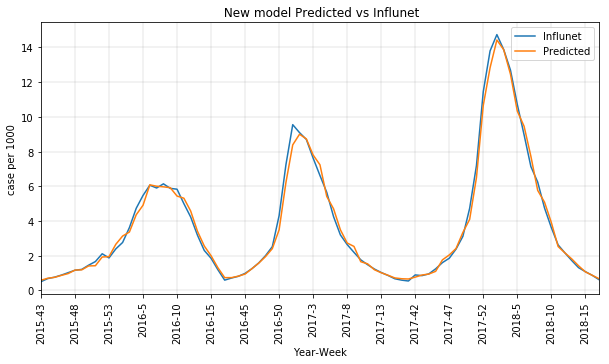

In [49]:
pp=np.array(pred)   #predicted results from the model
predicted=np.mean(pp, axis=0)     #taking mean value for each fold predicted values
new_data['Predicted']=predicted           #add new column for predicted
index=[]
index=new_data['Year'].apply(str)+"-"+new_data['Week'].apply(str)

ax=new_data.plot(x=index, y=['Influnet','Predicted'], title=" New model Predicted vs Influnet",rot=90, figsize=(10,5), legend=True,
            kind="line", xticks=range(0, 83, 5))


ax.set_xlabel("Year-Week")
ax.set_ylabel("case per 1000")
ax.grid( linewidth='0.2', color='grey')
plt.show()

This new model shows slightly more accurate result than previous model. Final RMSE value is 1.29 and norm_RMSE is 9.04%, getting accurate by 2%. Finally, this model can be improved further by adding new pages from Wikipedia/Google Trend and other sources, and increasing number of data, since I have data for only 84 weeks. 